# Offers in flight regression

In [335]:
import pandas as pd
import numpy as np
import random as rnd
import seaborn as sns
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import metrics 
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor,GradientBoostingRegressor
from sklearn.feature_extraction import DictVectorizer as DV
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.model_selection import KFold
from datetime import datetime
from sklearn import preprocessing
from sklearn.model_selection import learning_curve

%matplotlib inline


## Read Data

In [336]:
import sqlalchemy
import psycopg2
from sqlalchemy import create_engine
import json
import boto3
import base64

%load_ext sql
 
%config SqlMagic.displaylimit = 5
credfile = '../../redshift_creds_template.json.nogit'

with open(credfile) as fh:
    creds = json.loads(fh.read())
 
%config SqlMagic.displaylimit = 5


from sagemaker import get_execution_role
session = boto3.session.Session()
kms = session.client('kms')
encrypted_user = creds['username']
encrypted_pass = creds['password']
binary_data = base64.b64decode(encrypted_user)
meta = kms.decrypt(CiphertextBlob=binary_data)
user = meta[u'Plaintext']
binary_data = base64.b64decode(encrypted_pass)
meta2 = kms.decrypt(CiphertextBlob=binary_data)
passwd = meta2[u'Plaintext']
connect_to_db = 'postgresql+psycopg2://' + \
                user.decode() + ':' + passwd.decode() + '@' + \
                creds['host_name'] + ':' + creds['port_num'] + '/' + creds['db_name'];

engine = create_engine(connect_to_db)
con = engine.connect()


The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [337]:
query="""
SELECT * FROM ml_prep.gauthier_closed_door_slider_values_all WHERE 
departure_local_date_time >= '2019-11-01 11:00:00' AND departure_local_date_time < '2020-02-01 11:00:00' 
AND slider_lower_limit_usd IS NOT NULL;
"""
raw_df = pd.read_sql_query(query, con)
raw_df.head(3)


flight_number carrier_code origination destination cabin_type  \
0            807           CM         JFK         PTY   BUSINESS   
1             81           EY         AUH         MXP   BUSINESS   
2            436           CM         LIM         PTY   BUSINESS   

  scheduled_departure_local_date_time scheduled_arrival_local_date_time  \
0                 2019-11-02 01:55:00               2019-11-02 06:19:00   
1                 2019-11-02 02:45:00                                     
2                 2019-11-02 06:43:00               2019-11-02 10:29:00   

  departure_local_date_time arrival_local_date_time  departure_date_utc  ...  \
0       2019-11-02 01:55:00     2019-11-02 06:19:00 2019-11-02 05:55:00  ...   
1       2019-11-02 02:45:00                         2019-11-01 22:45:00  ...   
2       2019-11-02 06:43:00     2019-11-02 10:29:00 2019-11-02 11:43:00  ...   

  flight_availability_version  flight_inventory_event_date  \
0                        1.20                          NaT   
1                        1.20                          NaT   
2                        1.20                          NaT   

   flight_inventory_version  inventory_departure_local_date_time  \
0                                                            NaT   
1                                                            NaT   
2                                                            NaT   

   inventory_arrival_local_date_time         update_time  \
0                                NaT 2020-07-30 12:01:48   
1                                NaT 2020-07-30 12:01:48   
2                                NaT 2020-07-30 12:01:48   

   slider_lower_limit_usd  slider_start_usd  slider_upper_limit_usd  \
0                200.0000          250.0000                400.0000   
1                 55.6907           65.8234                101.2711   
2                140.0000          195.0000                300.0000   

   slider_step_usd  
0           5.0000  
1           5.6105  
2           5.0000  

[3 rows x 55 columns]

In [338]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385678 entries, 0 to 385677
Data columns (total 55 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   flight_number                           385678 non-null  int64         
 1   carrier_code                            385678 non-null  object        
 2   origination                             385678 non-null  object        
 3   destination                             385678 non-null  object        
 4   cabin_type                              385678 non-null  object        
 5   scheduled_departure_local_date_time     385678 non-null  object        
 6   scheduled_arrival_local_date_time       385678 non-null  object        
 7   departure_local_date_time               385678 non-null  object        
 8   arrival_local_date_time                 385678 non-null  object        
 9   departure_date_utc                   

# Feature Engineering

In [339]:
#drop non relevant fields
df = raw_df.drop(['average_upgrade_estimation_method_1m',
                  'average_upgrade_estimation_method_3m',
                  'average_upgrade_estimation_method_6m',
                  'average_upgrade_estimation_method_12m',
                 'flight_availability_event_date',
                 'flight_availability_version',
                 'flight_inventory_event_date',
                 'flight_inventory_version',
                 'inventory_departure_local_date_time',
                 'inventory_arrival_local_date_time',
                 'update_time',
                 'estimated_lost_revenue_usd_1m',
                 'estimated_lost_revenue_usd_3m',
                 'estimated_lost_revenue_usd_6m',
                 'estimated_lost_revenue_usd_12m',
                 'last_check_minutes',
                 'raw_available_count',
                 'waitlisted_seats',
                 'booked_seats',
                 'partner_code',
                 'partner_name',
                 'upgrade_item_count_sum',
                 'scheduled_departure_local_date_time',
                 'scheduled_arrival_local_date_time'], axis=1)



In [340]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385678 entries, 0 to 385677
Data columns (total 31 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   flight_number                           385678 non-null  int64         
 1   carrier_code                            385678 non-null  object        
 2   origination                             385678 non-null  object        
 3   destination                             385678 non-null  object        
 4   cabin_type                              385678 non-null  object        
 5   departure_local_date_time               385678 non-null  object        
 6   arrival_local_date_time                 385678 non-null  object        
 7   departure_date_utc                      385678 non-null  datetime64[ns]
 8   arrival_date_utc                        380487 non-null  datetime64[ns]
 9   authorized_capacity                  

In [341]:
# compute some time-related features
# this takes some time

def feature_engineering(df):
    df['departure_hour'] = pd.to_datetime(df['departure_local_date_time']).apply(lambda x: x.hour)
    df['departure_day_of_week']= pd.to_datetime(df['departure_local_date_time']).apply(lambda x: x.dayofweek)
    df['departure_month']= pd.to_datetime(df['departure_local_date_time']).apply(lambda x: x.month)
    df['departure_year']= pd.to_datetime(df['departure_local_date_time']).apply(lambda x: x.year)
    
    df['arrival_hour'] = pd.to_datetime(df['arrival_local_date_time']).apply(lambda x: x.hour).fillna(0)
    df['arrival_day_of_week']= pd.to_datetime(df['arrival_local_date_time']).apply(lambda x: x.dayofweek).fillna(0)
    df['arrival_month']= pd.to_datetime(df['arrival_local_date_time']).apply(lambda x: x.month).fillna(0)
    df['arrival_year']= pd.to_datetime(df['arrival_local_date_time']).apply(lambda x: x.year).fillna(0)

    df['origination_destination'] = df['origination']+ df['destination']
    df['origination_destination_country'] = df['origination_country']+ df['destination_country']
    df['origination_destination_city'] = df['origination_city']+ df['destination_city']
    df['offer_submitted_seats'] = df['offer_submitted_item_count_sum']+ df['offer_cancelled_item_count_sum']

    df['operational_capacity'] = df['operational_capacity'].fillna(0)
    df['authorized_capacity'] = df['authorized_capacity'].fillna(0)

    df['load_factor'] = df['load_factor'].fillna(0)
    
    
    df['slider_lower_limit_usd'] = df['slider_lower_limit_usd'].fillna(0)
    df['slider_start_usd'] = df['slider_start_usd'].fillna(0)
    df['slider_upper_limit_usd'] = df['slider_upper_limit_usd'].fillna(0)
    df['slider_step_usd'] = df['slider_step_usd'].fillna(0)

    return df

df = feature_engineering(df)
raw_df = feature_engineering(raw_df)


In [342]:
df[['offer_submitted_seats','offer_submitted_item_count_sum','offer_cancelled_item_count_sum']][:3]

offer_submitted_seats  offer_submitted_item_count_sum  \
0                      1                               1   
1                     10                               8   
2                      2                               2   

   offer_cancelled_item_count_sum  
0                               0  
1                               2  
2                               0

In [343]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385678 entries, 0 to 385677
Data columns (total 43 columns):
 #   Column                                  Non-Null Count   Dtype         
---  ------                                  --------------   -----         
 0   flight_number                           385678 non-null  int64         
 1   carrier_code                            385678 non-null  object        
 2   origination                             385678 non-null  object        
 3   destination                             385678 non-null  object        
 4   cabin_type                              385678 non-null  object        
 5   departure_local_date_time               385678 non-null  object        
 6   arrival_local_date_time                 385678 non-null  object        
 7   departure_date_utc                      385678 non-null  datetime64[ns]
 8   arrival_date_utc                        380487 non-null  datetime64[ns]
 9   authorized_capacity                  

# Feature Encoding

In [344]:
# for random forest, no need to one-hot-encode
def label_encode_categorical(df, columns):
    train_df_fact = df.copy()
    for column in columns:
        print('label encoding',column,'...')
        encoder = preprocessing.LabelEncoder()
        encoder.fit(train_df_fact[column])
        train_df_fact[column+'_encoded'] = encoder.transform(train_df_fact[column])
    return train_df_fact


In [345]:
# label-encode categories
df= label_encode_categorical(df,['carrier_code',
                                 'origination',
                                 'destination',
                                 'cabin_type',
                                 'origination_destination',
                                 'origination_country',
                                 'origination_city',
                                 'destination_country',
                                 'destination_city',
                                 'origination_destination_country',
                                 'origination_destination_city'])

label encoding carrier_code ...
label encoding origination ...
label encoding destination ...
label encoding cabin_type ...
label encoding origination_destination ...
label encoding origination_country ...
label encoding origination_city ...
label encoding destination_country ...
label encoding destination_city ...
label encoding origination_destination_country ...
label encoding origination_destination_city ...


In [346]:
df.head(3)

flight_number carrier_code origination destination cabin_type  \
0            807           CM         JFK         PTY   BUSINESS   
1             81           EY         AUH         MXP   BUSINESS   
2            436           CM         LIM         PTY   BUSINESS   

  departure_local_date_time arrival_local_date_time  departure_date_utc  \
0       2019-11-02 01:55:00     2019-11-02 06:19:00 2019-11-02 05:55:00   
1       2019-11-02 02:45:00                         2019-11-01 22:45:00   
2       2019-11-02 06:43:00     2019-11-02 10:29:00 2019-11-02 11:43:00   

     arrival_date_utc  authorized_capacity  ...  origination_encoded  \
0 2019-11-02 11:19:00                  0.0  ...                  217   
1                 NaT                 22.0  ...                   28   
2 2019-11-02 15:29:00                  0.0  ...                  258   

   destination_encoded  cabin_type_encoded  origination_destination_encoded  \
0                  371                   0                             1454   
1                  310                   0                              232   
2                  371                   0                             1762   

   origination_country_encoded  origination_city_encoded  \
0                          149                       319   
1                          147                         3   
2                          106                       249   

   destination_country_encoded  destination_city_encoded  \
0                          103                       342   
1                           70                       292   
2                          103                       342   

   origination_destination_country_encoded  \
0                                     1190   
1                                     1115   
2                                      783   

   origination_destination_city_encoded  
0                                  2223  
1                                    63  
2                                  1558  

[3 rows x 54 columns]

In [347]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385678 entries, 0 to 385677
Data columns (total 54 columns):
 #   Column                                   Non-Null Count   Dtype         
---  ------                                   --------------   -----         
 0   flight_number                            385678 non-null  int64         
 1   carrier_code                             385678 non-null  object        
 2   origination                              385678 non-null  object        
 3   destination                              385678 non-null  object        
 4   cabin_type                               385678 non-null  object        
 5   departure_local_date_time                385678 non-null  object        
 6   arrival_local_date_time                  385678 non-null  object        
 7   departure_date_utc                       385678 non-null  datetime64[ns]
 8   arrival_date_utc                         380487 non-null  datetime64[ns]
 9   authorized_capacity       

In [348]:
columns_for_training= [
    
             #'cabin_type',
    
            # o/d
            'origination_encoded',
            'origination_city_encoded',
            'origination_country_encoded',
            'destination_encoded',
            'destination_city_encoded',
            'destination_country_encoded',
            'origination_destination_encoded',
            'origination_destination_country_encoded',
            'origination_destination_city_encoded',
            
            # departure time
            'departure_hour',
            'departure_day_of_week',
            'departure_month',
            'departure_year',
    
            # arrival time
            'arrival_hour',
            'arrival_day_of_week',
            'arrival_month',
            'arrival_year',

            # cabin capacity
            'authorized_capacity',
            'operational_capacity',
    
            # slider
            'slider_lower_limit_usd',
            'slider_start_usd',
            'slider_upper_limit_usd',
            'slider_step_usd',
    
            
            #'load_factor',
    
            # historical average upgrade amount
            #'average_upgrade_amount_usd_1m',
            #'average_upgrade_amount_usd_3m',
            #'average_upgrade_amount_usd_6m',
            #'average_upgrade_amount_usd_12m',
    
            # the rest
            'flight_distance_miles',
            'flight_number',
            'carrier_code_encoded',
            'partner_id',

            # target
            'offer_submitted_seats'
                      ]

df_train = df[columns_for_training]

In [349]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 385678 entries, 0 to 385677
Data columns (total 28 columns):
 #   Column                                   Non-Null Count   Dtype  
---  ------                                   --------------   -----  
 0   origination_encoded                      385678 non-null  int64  
 1   origination_city_encoded                 385678 non-null  int64  
 2   origination_country_encoded              385678 non-null  int64  
 3   destination_encoded                      385678 non-null  int64  
 4   destination_city_encoded                 385678 non-null  int64  
 5   destination_country_encoded              385678 non-null  int64  
 6   origination_destination_encoded          385678 non-null  int64  
 7   origination_destination_country_encoded  385678 non-null  int64  
 8   origination_destination_city_encoded     385678 non-null  int64  
 9   departure_hour                           385678 non-null  int64  
 10  departure_day_of_week           

In [350]:
df_train.head(4)

origination_encoded  origination_city_encoded  origination_country_encoded  \
0                  217                       319                          149   
1                   28                         3                          147   
2                  258                       249                          106   
3                  350                       348                          149   

   destination_encoded  destination_city_encoded  destination_country_encoded  \
0                  371                       342                          103   
1                  310                       292                           70   
2                  371                       342                          103   
3                  191                       195                          149   

   origination_destination_encoded  origination_destination_country_encoded  \
0                             1454                                     1190   
1                              232                                     1115   
2                             1762                                      783   
3                             2394                                     1202   

   origination_destination_city_encoded  departure_hour  ...  \
0                                  2223               1  ...   
1                                    63               2  ...   
2                                  1558               6  ...   
3                                  2436               8  ...   

   operational_capacity  slider_lower_limit_usd  slider_start_usd  \
0                   0.0                200.0000          250.0000   
1                  22.0                 55.6907           65.8234   
2                   0.0                140.0000          195.0000   
3                  18.0                375.0000          695.0000   

   slider_upper_limit_usd  slider_step_usd  flight_distance_miles  \
0                400.0000           5.0000                   2220   
1                101.2711           5.6105                   2945   
2                300.0000           5.0000                   1474   
3                950.0000           5.0000                   2929   

   flight_number  carrier_code_encoded  partner_id  offer_submitted_seats  
0            807                     4         230                      1  
1             81                     6          11                     10  
2            436                     4         230                      2  
3             35                    10          13                      8  

[4 rows x 28 columns]

In [351]:
df_train.groupby('offer_submitted_seats').size()

offer_submitted_seats
0     217714
1      57568
2      39993
3      20924
4      15196
5       9378
6       6641
7       4568
8       3289
9       2389
10      1649
11      1347
12      1014
13       723
14       616
15       493
16       365
17       322
18       264
19       186
20       156
21       132
22       133
23        87
24        85
25        66
26        66
27        47
28        37
29        28
30        30
31        26
32        14
33        16
34        17
35        10
36        21
37         9
38         7
39         5
40         5
41         5
42         5
43         7
44         1
45         3
46         5
47         2
50         5
51         2
52         2
56         1
57         1
58         2
64         1
dtype: int64

In [352]:
df_train.groupby('departure_year').size()

departure_year
2019    227307
2020    158371
dtype: int64

# Model Training & Evaluation

In [353]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d",cbar=False)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [354]:
def train_and_evaluate(df_to_train, plot_learning_curves=False, limit=None, split_on_time=False,plot_sample_predicted_vs_actual=False, sim=False):
    # X-validation
    
    if limit is not None:
        #pick them randomly
        df_to_train = df_to_train.sample(n=limit)

    random_forest =  RandomForestRegressor(n_estimators=100)
    X = df_to_train.drop("offer_submitted_seats", axis=1)
    y = df_to_train["offer_submitted_seats"]
        
    if split_on_time:
        X_train = X[X["departure_year"] == 2019 ].drop("departure_year", axis=1)
        y_train = y[X["departure_year"] == 2019]
        X_test = X[X["departure_year"] == 2020].drop("departure_year", axis=1)
        y_test = y[X["departure_year"] == 2020]
        pass
    else:
        X = X.drop("submission_year", axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.30, random_state=42)

    # train
    print('training on', str(len(X_train)), 'rows...')
    random_forest.fit(X_train, y_train)
    print('training is done!')
    print('testing on', str(len(X_test)), 'rows...')


    # predict
    y_test_predict = random_forest.predict(X_test)

    print('sum of predicted : ', y_test_predict.sum())
    print('sum of actual : ', y.sum())
    
    print('Lower is better')
    print('mean_squared_error',str(metrics.mean_squared_error(y_test,y_test_predict)))
    print('mean_absolute_error',str(metrics.mean_absolute_error(y_test,y_test_predict)))
    print('median_absolute_error',str(metrics.median_absolute_error(y_test,y_test_predict)))

    print('Higher is better')
    print('explained_variance_score',str(metrics.explained_variance_score(y_test,y_test_predict)))
    print('r2_score',str(metrics.r2_score(y_test,y_test_predict)))

    
    if plot_sample_predicted_vs_actual:
        
        random_indices = np.random.choice(len(y_test), size=300, replace=False)

        sample_actual=y_test.values[random_indices]
        sample_predict = y_test_predict[random_indices]
        
        plt.figure(figsize=(16,9))
        plt.title('Predicted vs Actual')
        plt.scatter(sample_actual, sample_predict)
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.show()

    # Plot the impurity-based feature importances of the forest
    features = X_train.columns
    importances = random_forest.feature_importances_
    indices = np.argsort(importances)[::-1]
    plt.figure(figsize=(16,9))
    plt.title('Feature Importances')
    plt.bar(range(len(indices)), importances[indices], color='b', align='center')   
    plt.xticks(range(X_train.shape[1]), features[indices],rotation=90)
    plt.show()

    if plot_learning_curves:
        scoring = 'neg_mean_squared_error'
        print('Computing Learning curves...')
        train_sizes, train_scores, test_scores = \
                learning_curve(random_forest, X, y, train_sizes=np.linspace(0.1, 1.0, 5), scoring=scoring, cv=3)
        train_scores_mean = np.mean(train_scores, axis=1)
        train_scores_std = np.std(train_scores, axis=1)
        test_scores_mean = np.mean(test_scores, axis=1)
        test_scores_std = np.std(test_scores, axis=1)

        plt.figure(figsize=(16,9))
        # Plot learning curve
        plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                             train_scores_mean + train_scores_std, alpha=0.1, color="r")
        plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                             test_scores_mean + test_scores_std, alpha=0.1, color="g")
        plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
        plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
        plt.legend(loc="best")
        plt.xlabel("Training examples")
        plt.ylabel(scoring)
        plt.title("Learning Curves")


        print(train_sizes)
        print(train_scores)
        print(test_scores)
        
    if sim:
        
        print('RUNNING DIFFERENT SLIDER VALUES SIMULATION . . . . .')
        
        #print('Current slider values predicted : ', y_test_predict.sum())
        #print('Current slider values actual : ', y.sum())

        modified_X_test = X_test.copy()
        
        modifiers = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.5, 3.0]
        
        
        ## TODO gauthier :  try per partner (global model + per partner model)
        
        results = []
        for modifier in modifiers:
            modified_X_test['slider_lower_limit_usd'] = X_test ['slider_lower_limit_usd'] * modifier
            modified_X_test['slider_start_usd'] = X_test ['slider_start_usd'] * modifier
            modified_X_test['slider_upper_limit_usd'] = X_test ['slider_upper_limit_usd'] * modifier
            
            # predict
            y_test_predict_current = random_forest.predict(modified_X_test)
            the_sum = y_test_predict_current.sum()
            print('Slider values modifier: x' + str(modifier), 'gives the expected seats with offer:', y_test_predict_current.sum())
            results.append(the_sum)
        plt.figure(figsize=(16,9))
        plt.plot (modifiers,results,marker='o')
        plt.axhline(results[modifiers.index(1.0)], color= 'r', label='Baseline (predict seats with offer with no modifier)')
        plt.legend()
        #plt.xticks(range(min(modifiers),max(modifiers)))
        plt.show()
        

training on 227307 rows...
training is done!
testing on 158371 rows...
sum of predicted :  245521.7664483572
sum of actual :  542798
Lower is better
mean_squared_error 5.4208218467323634
mean_absolute_error 1.3510856366068382
median_absolute_error 0.808920634920635
Higher is better
explained_variance_score 0.3325805203114228
r2_score 0.32764849541399543


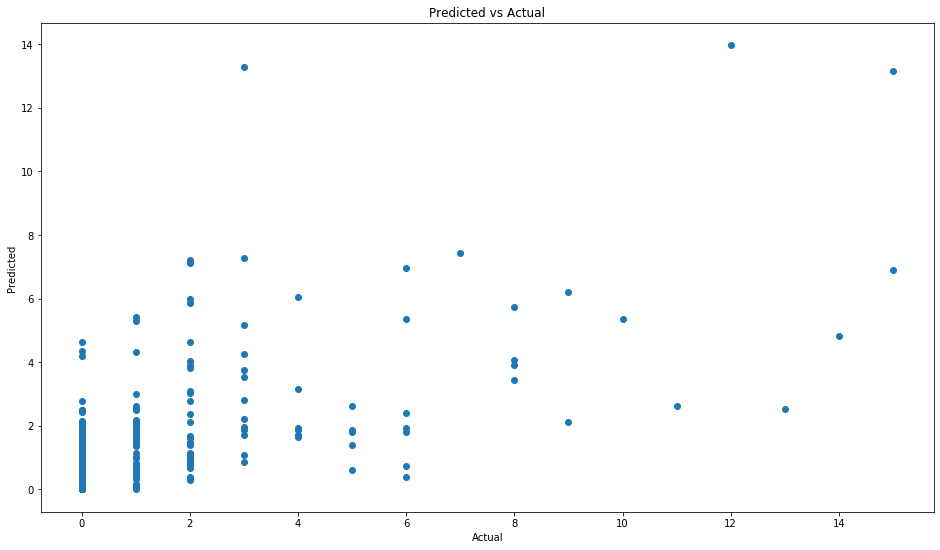

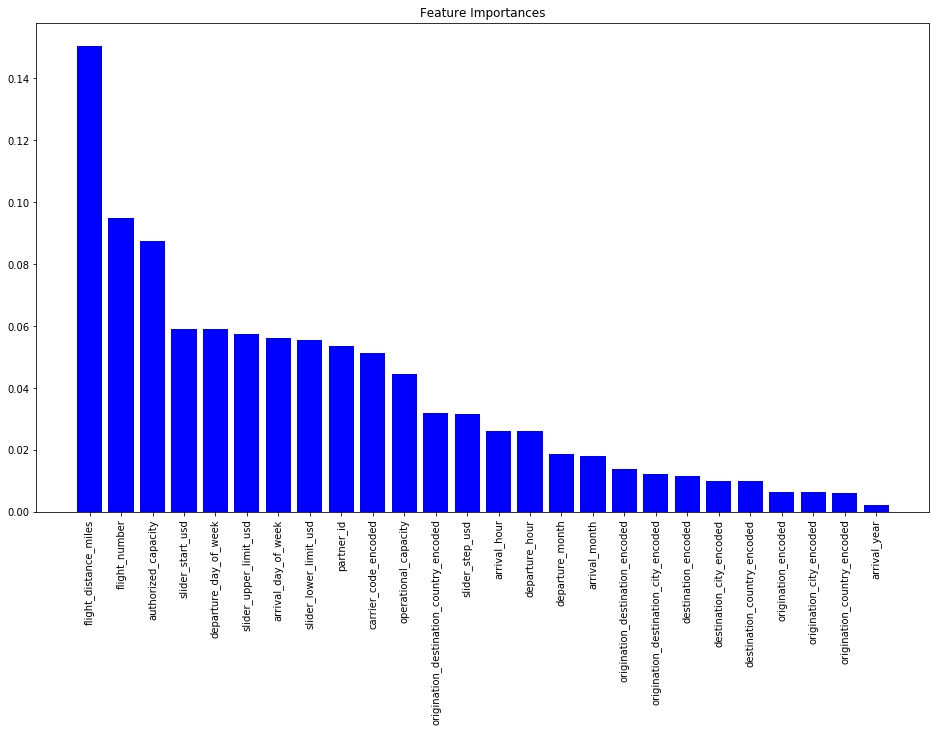

RUNNING DIFFERENT SLIDER VALUES SIMULATION . . . . .
Slider values modifier: x0.1 gives the expected seats with offer: 326374.5084614274
Slider values modifier: x0.2 gives the expected seats with offer: 327334.46617427026
Slider values modifier: x0.3 gives the expected seats with offer: 325844.4197741981
Slider values modifier: x0.4 gives the expected seats with offer: 324600.7172776113
Slider values modifier: x0.5 gives the expected seats with offer: 316375.64395337994
Slider values modifier: x0.6 gives the expected seats with offer: 305227.5496463814
Slider values modifier: x0.7 gives the expected seats with offer: 293480.6854918416
Slider values modifier: x0.8 gives the expected seats with offer: 279521.21349100897
Slider values modifier: x0.9 gives the expected seats with offer: 263906.84525746474
Slider values modifier: x1.0 gives the expected seats with offer: 245521.7664483572
Slider values modifier: x1.1 gives the expected seats with offer: 252942.12558793987
Slider values modi

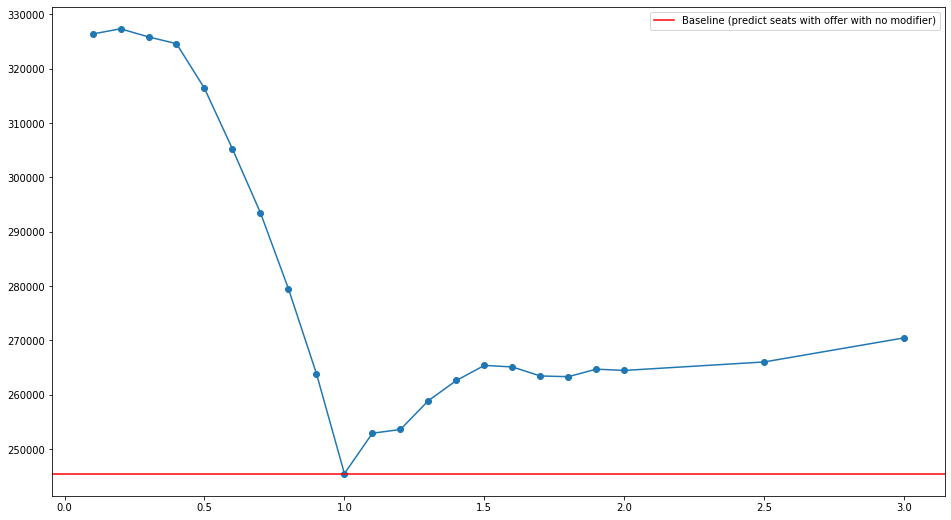

In [355]:
# run with a lot of data
train_and_evaluate(df_train,limit=None,plot_learning_curves=False, split_on_time=True,plot_sample_predicted_vs_actual=True, sim=True)